In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Корень проекта.
DIR_ROOT = Path.cwd().parent.parent
# Путь к удаленной директории с ресурсами: данные, модели и т.д.
DIR_REMOTE: Path | None = Path('/home/admin/cafa/resources')

if DIR_REMOTE is not None and DIR_REMOTE.exists():
    DIR_RESOURCE = DIR_REMOTE
else:
    DIR_RESOURCE = DIR_ROOT

# Загрузка исходного датасета

In [17]:
train_terms = pd.read_csv(
    DIR_RESOURCE / 'data/raw/Train/train_terms.tsv',
    sep='\t'
)
print(train_terms.shape)
print(round(train_terms.memory_usage().sum() / 1024**3, 2), 'GB')

(5363863, 3)
0.12 GB


`train_terms` состоит из 3-х столбцов и 5_363_863 записей.

In [18]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


# Загрузка IA коэффициентов

In [19]:
ia_df = pd.read_csv(
    DIR_RESOURCE / 'data/raw/IA.txt',
    sep="\t",
    names=['term', 'ia'],
)
print(ia_df.shape)
ia_df.head()

(43248, 2)


,term,ia
0,GO:0000001,0.000000
1,GO:0000002,3.103836
2,GO:0000003,3.439404
3,GO:0000011,0.056584
4,GO:0000012,6.400377


# Добавление IA колонки к `train_terms`

In [20]:
train_terms = pd.merge(
    train_terms,
    ia_df,
    on='term',
    how='inner',
)
print(train_terms.shape)
train_terms.head()

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A023I7E1,GO:0008152,BPO,1.598544
2,A0A024CBD6,GO:0008152,BPO,1.598544
3,A0A024RAD5,GO:0008152,BPO,1.598544
4,A0A031WDE4,GO:0008152,BPO,1.598544


# Загрузка подготовленных embeddings белков

Данные (embeddings белков) подготовлены [Sergei Fironov](https://www.kaggle.com/sergeifironov) с использованием модели для белков Rost Lab T5. 

In [6]:
# Загрузка id белков, используемых далее для определения embeddings.
train_protein_ids = np.load(
    DIR_RESOURCE / 'data/interim/t5embeds/train_ids.npy'
)
print(train_protein_ids.shape)

(142246,)


In [7]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

In [8]:
train_embeddings = np.load(
    DIR_RESOURCE / 'data/interim/t5embeds/train_embeds.npy'
)

# Трансформация embeddings в `pandas` датафрейм.
column_num = train_embeddings.shape[1]
train_features_df = pd.DataFrame(
    train_embeddings,
    columns = ["Column_" + str(i) for i in range(1, column_num+1)]
)
# Удаление неиспользуемых в дальнейшем объектов.
del train_embeddings
print(train_features_df.shape)
print(round(train_features_df.memory_usage().sum() / 1024**3, 2), 'GB')

(142246, 1024)
1.09 GB


`train_features_df` состоит из 1024 признаков и 142_246 записей (различных белков)

In [9]:
train_features_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Подготовка датасета (признаков и целей)
Датасет готовится в соответсвии, что задача: multi label model classification.


## Предобработка данных
Т.к. GO-термов болльше 40_000, а по условию можно подавать результаты предсказаний не более 1500 аннотаций для одного белка, то ограничемся использованием только наиболее частовстречающиемися 1500 GO-термами из тренировочных данных.

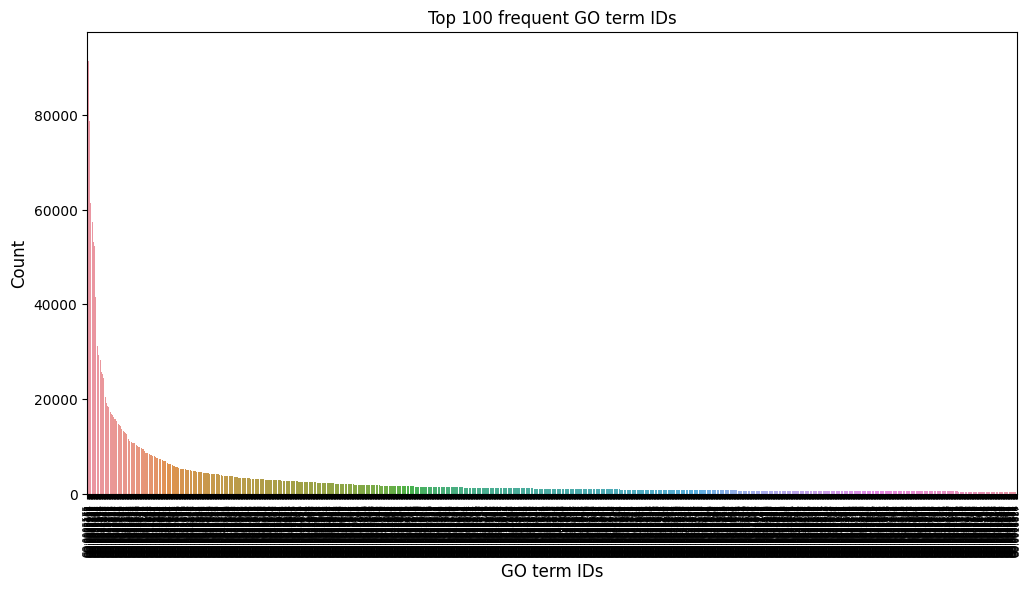

In [45]:
# Выбор наиболее популярных 100 GO-термов.
plot_df = train_terms['term'].value_counts().iloc[:1500]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel('GO term IDs', fontsize = 12)
bp.set_ylabel('Count', fontsize = 12)
plt.show()

## Формирование тренирововчных данных с отбором по IA (не закончено)

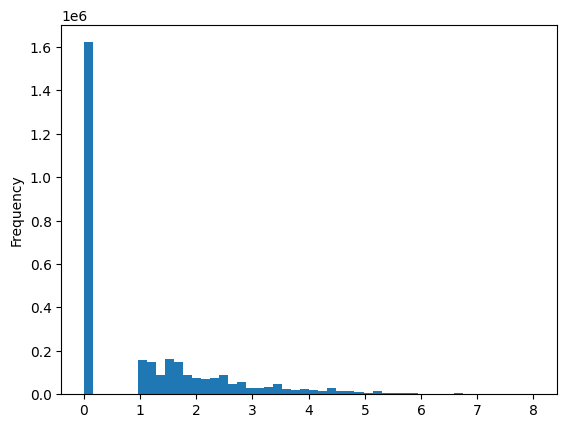

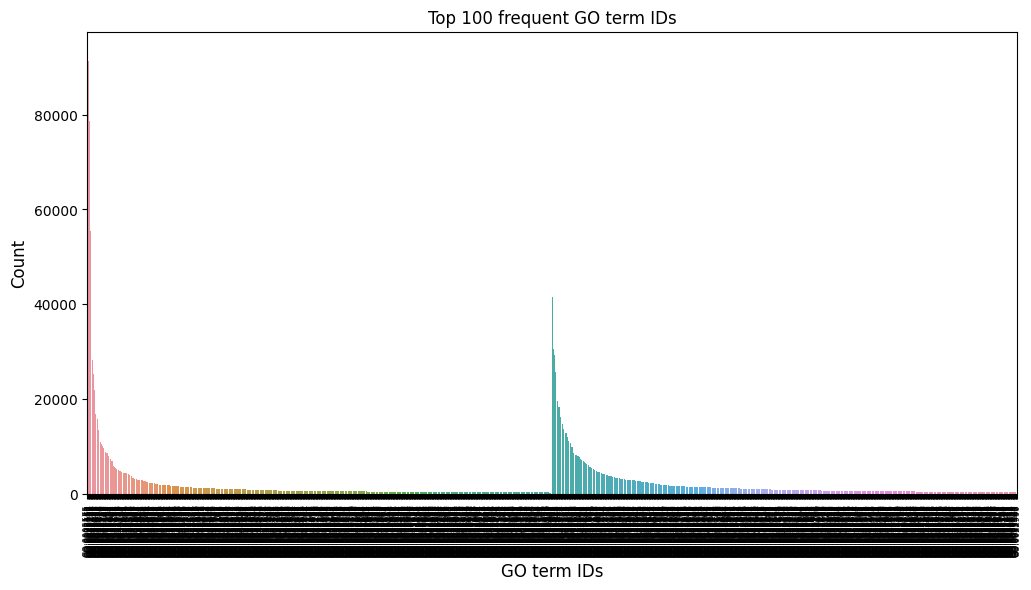

In [59]:
THRESHOLD_LOWER = 0.14
THRESHOLD_UPPER = 1.0
CNT_LOWER = 750
CNT_UPPER = 750
# Серия с наиболее частовстречающимися GO-термами с низким IA
# (термы наиболее близки к корню в DAG)
top_low_ia = (
    train_terms[train_terms['ia'] <= THRESHOLD_LOWER]['term']
    .value_counts()
    .iloc[:CNT_LOWER]
)
# Серия с наиболее частовстречающимися GO-термами с высокими IA
# (термы далекие от корня в DAG)
top_high_ia = (
    train_terms[train_terms['ia'] >= THRESHOLD_UPPER]['term']
    .value_counts()
    .iloc[:CNT_UPPER]
)

terms = pd.concat([top_low_ia, top_high_ia])
# Распределение IA-значений в выбранных термах.
(
    train_terms[
        train_terms['term'].isin(terms.keys())
    ]['ia']
    .plot(kind='hist', bins=50)
)
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(terms.index), y=terms.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel('GO term IDs', fontsize = 12)
bp.set_ylabel('Count', fontsize = 12)
plt.show()

## Формируем список 1500 популярных GO-термов

In [21]:
# Кол-во используемых GO-термов.
num_of_labels = 1500

# Цели, которые ограничены популярными GO-термами в кол-ве `num_of_labels`.
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

Формируем массив соответсвубищих IA-коэффициентов.

In [22]:
# Фильтрация `train_terms` по отобранным GO-термам.
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
# Промежуточный датафрейм для формирования единой индексации "term" и "ia".
term_ia_df = (
    train_terms_updated[['term', 'ia']]
    .drop_duplicates()
    .reset_index(drop=True)
)
# Перезапись `labels` с возможно новым порядком GO-термов.
labels = term_ia_df['term'].tolist()
# Соответсвующий `labels` массив ia-коэф.
ia_arr = term_ia_df['ia'].to_numpy()
# Удаление неиспользуемых в дальнейшем объектов.
del train_terms

In [23]:
train_terms_updated

,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A023I7E1,GO:0008152,BPO,1.598544
2,A0A024CBD6,GO:0008152,BPO,1.598544
3,A0A024RAD5,GO:0008152,BPO,1.598544
4,A0A031WDE4,GO:0008152,BPO,1.598544
...,...,...,...,...
5306845,Q9Y2M0,GO:0004519,MFO,0.799087
5306846,Q9ZJ19,GO:0004519,MFO,0.799087
5306847,Q9ZVD5,GO:0004519,MFO,0.799087
5306848,Q9ZZX1,GO:0004519,MFO,0.799087


In [24]:
term_ia_df

,term,ia
0,GO:0008152,1.598544
1,GO:0034655,0.042274
2,GO:0044270,0.281155
3,GO:0006753,0.013844
4,GO:0044237,0.103670
...,...,...
1495,GO:0003924,0.913082
1496,GO:0003735,0.911680
1497,GO:0004518,1.944116
1498,GO:0004540,0.019236


Распределение аспектов в GO для обновленных данных `train_terms_updated`

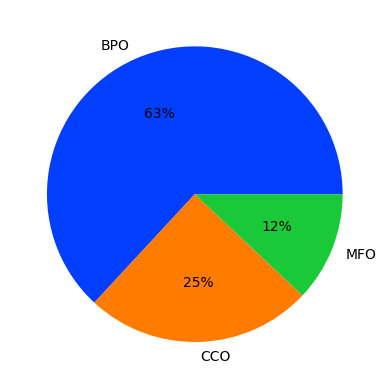

In [29]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

## Непосредственное формирование целей
Непосредственное формирование датафрейма (таблицы целей для случая multi label classification) по отобранным GO-термам.

In [30]:
# Формирование нулевой матрицы с необходимыми размерами:
# например train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0]
train_labels = np.zeros((train_size ,num_of_labels))

# Конвертация `numpy` одномерного массива в `pandas.Series`.
series_train_protein_ids = pd.Series(train_protein_ids)

# Проход по каждому уникальному GO-терму.
for i in range(num_of_labels):
    # Для каждого label чтение сответсвующих данных `train_terms`
    n_train_terms = train_terms_updated[
        train_terms_updated['term'] == labels[i]
    ]

    # Выбор подмножества с уникальными EntryId (названиями белков) для
    # текущей цели (GO-терм). Не уникальность связана с 3-мя типами аспектов.
    label_related_proteins = n_train_terms['EntryID'].unique()

    # В серии `series_train_protein_ids` pandas, если белок связан
    # с текущей целью, то ей присваивается 1, иначе 0
    # (через конвертацию bool в float).
    #  Замена i-го столбеца в `train_labels` на эту серию.
    train_labels[:,i] =  (
        series_train_protein_ids
        .isin(label_related_proteins)
        .astype(float)
    )

# Конвертация матрицы из numpy в pandas датафрейм.
labels_df = pd.DataFrame(data = train_labels, columns = labels)
labels_df = labels_df.astype('int32')
print(labels_df.shape)
print(round(labels_df.memory_usage().sum() / 1024**3, 2), 'GB')

(142246, 1500)
0.79 GB


## Сохранение подготовленых признаков и целей.

In [31]:
# Сохранение признаков.
train_features_df.to_csv(
    DIR_RESOURCE / 'data/prepared/train_features_v2.csv',
    index=False,
)
# Сохранение целей.
labels_df.to_csv(
    DIR_RESOURCE / 'data/prepared/train_lbls_top1500_goterms_v2.csv',
    index=False,
)
# Сохранение массива IA, соответсвующих GO-термам из `labels_df`
# в том же порядке следования.
np.save(
    DIR_RESOURCE / 'data/prepared/ai_arr_top1500_goterms_v2',
    arr=ia_arr,
)